In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from SEGAN_model import *

import librosa
import os
import pesq

import IPython.display as ipd

devices=tf.config.list_physical_devices('GPU')
for i in range(len(devices)):
  tf.config.experimental.set_memory_growth(devices[i],True)

In [2]:
g_opt=tf.keras.optimizers.RMSprop(learning_rate=0.0002)
d_opt=tf.keras.optimizers.RMSprop(learning_rate=0.0002)

generator=make_generator_model()
discriminator=make_discriminator_model()
GAN_model=GAN(generator,discriminator)
GAN_model.compile(g_opt,d_opt)

tf.keras.Model.load_weights(GAN_model,'1306_Model_GAN_custom_v2.ckpt')

In [3]:
def enhance_audio(generator,audio):
    audio=preemphasis(audio)
    enhanced=tf.signal.frame(audio,16384,16384,pad_end=True,axis=0)
    latent_vector=tf.random.normal([enhanced.shape[0],8,1024])
    enhanced=generator.predict([enhanced,latent_vector])
    enhanced=tf.reshape(enhanced,[enhanced.shape[0]*enhanced.shape[1],1]).numpy()
    enhanced=enhanced[:audio.shape[0],:]
    enhanced=np.squeeze(enhanced)
    enhanced=deemphasis(enhanced)
    return enhanced

def print_spectogram(audio):
    audio_stft=librosa.stft(audio,n_fft=1024)
    audio_db=librosa.amplitude_to_db(np.abs(audio_stft),ref=np.max)
    return audio_db

def preemphasis(audio):
    return np.concatenate([[audio[0]],audio[1:]-0.95 * audio[:-1]],axis=0)

def deemphasis(audio):
    deemphasized_signal = np.zeros_like(audio)
    deemphasized_signal[0] = audio[0]
    for i in range(1, len(audio)):
        deemphasized_signal[i] = audio[i] + 0.95 * deemphasized_signal[i-1]
    return deemphasized_signal


In [4]:
noisy_data='Dataset/noisy/p226_007.wav'
noise,sr=librosa.load(noisy_data)
noise=librosa.resample(noise,orig_sr=sr,target_sr=16000)

enhanced_time=enhance_audio(generator,noise)

ipd.Audio(data=enhanced_time,rate=16000)

1/1 [==============================] - 4s 4s/step


pesq of noisy 1.1730728149414062
pesq of Enhanced_SEGAN 1.4866704940795898
pesq of clean 4.643888473510742


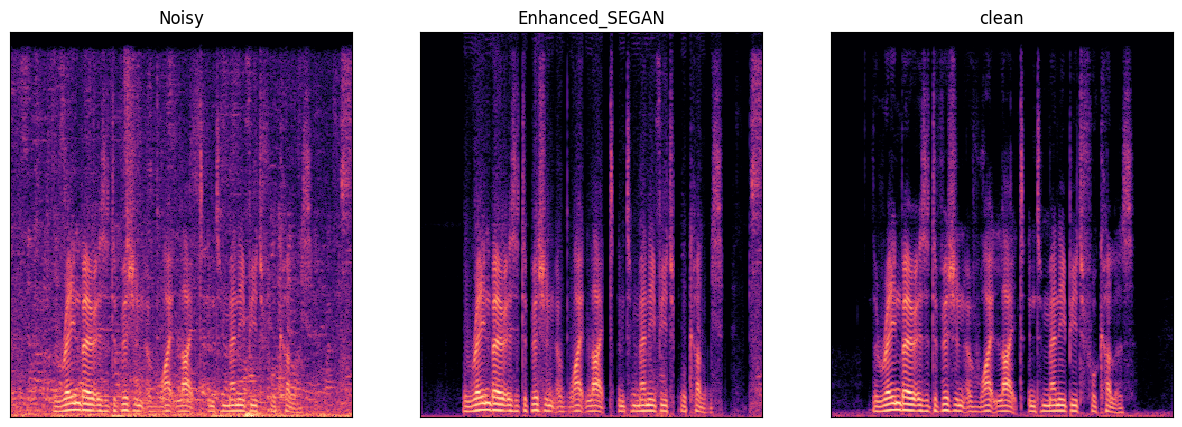

In [6]:
clean_data='Dataset/clean/p226_007.wav'
clean,sr2=librosa.load(clean_data)
clean=librosa.resample(clean,orig_sr=sr2,target_sr=16000)

noisy_pesq=pesq.pesq(16000,clean,noise)
enhanced_pesq=pesq.pesq(16000,clean,enhanced_time)
print("pesq of noisy",noisy_pesq)
print("pesq of Enhanced_SEGAN",enhanced_pesq)
print("pesq of clean",pesq.pesq(16000,clean,clean))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
librosa.display.specshow(print_spectogram(noise))
plt.title("Noisy")
plt.subplot(1,3,2)
librosa.display.specshow(print_spectogram(enhanced_time))
plt.title("Enhanced_SEGAN")
plt.subplot(1,3,3)
librosa.display.specshow(print_spectogram(clean))
plt.title("clean")
plt.show()